In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import time
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice
from keras.models import load_model

register_matplotlib_converters()

Using TensorFlow backend.


In [3]:
# from local data file
trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# convert geohash into latitude longitude

In [7]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [8]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# week 1, week 2, week 3 and week 4 data

In [9]:
initial_day = 1
num_of_days = 28
range_btwn_pts = 1 # in km
min_samples = 1
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_day) & (trf_df_sort.day < (initial_day + num_of_days))])

In [10]:
trf_week1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# day 1 to day 28 cluster

In [11]:
day_ids = list(range(1,num_of_days+1))
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day.isin(day_ids)])
latlon = trf_day1.groupby('geohash6')['geohash6'].unique().apply(lambda x: geohash.decode(x[0]))
coords = np.array([idx for idx in latlon])
#coords = trf_day1[['lat', 'lon']].values

In [12]:
start_time = time.time()
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
elapsed_time = time.time() - start_time
print('Time taken to cluster: {} secs'.format(elapsed_time))
print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Time taken to cluster: 0.04167747497558594 secs
Number of day 1 to day 28 clusters: 79


0     [[-5.48492431640625, 90.6536865234375], [-5.47...
1     [[-5.46295166015625, 90.6536865234375], [-5.45...
2     [[-5.48492431640625, 90.6646728515625], [-5.47...
3     [[-5.48492431640625, 90.6756591796875], [-5.47...
4     [[-5.48492431640625, 90.6866455078125], [-5.47...
5     [[-5.48492431640625, 90.6976318359375], [-5.47...
6     [[-5.41351318359375, 90.5877685546875], [-5.40...
7     [[-5.41351318359375, 90.5987548828125], [-5.40...
8     [[-5.41351318359375, 90.6097412109375], [-5.40...
9               [[-5.43548583984375, 90.6427001953125]]
10              [[-5.43548583984375, 90.6536865234375]]
11    [[-5.41351318359375, 90.6207275390625], [-5.40...
12    [[-5.41351318359375, 90.6317138671875], [-5.40...
13    [[-5.41351318359375, 90.6427001953125], [-5.40...
14    [[-5.41351318359375, 90.6536865234375], [-5.40...
15    [[-5.41900634765625, 90.6646728515625], [-5.41...
16    [[-5.30914306640625, 90.5987548828125], [-5.30...
17    [[-5.48492431640625, 90.7086181640625], [-

# cluster centermost_points

In [13]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (-5.48492431640625, 90.6536865234375)
1     (-5.45745849609375, 90.6536865234375)
2     (-5.45745849609375, 90.6646728515625)
3     (-5.36407470703125, 90.6756591796875)
4     (-5.36407470703125, 90.6866455078125)
5     (-5.36407470703125, 90.6976318359375)
6     (-5.36407470703125, 90.5877685546875)
7     (-5.36956787109375, 90.5987548828125)
8     (-5.35858154296875, 90.6097412109375)
9     (-5.43548583984375, 90.6427001953125)
10    (-5.43548583984375, 90.6536865234375)
11    (-5.35308837890625, 90.6207275390625)
12    (-5.34210205078125, 90.6317138671875)
13    (-5.32562255859375, 90.6427001953125)
14    (-5.32562255859375, 90.6536865234375)
15    (-5.32562255859375, 90.6646728515625)
16    (-5.30914306640625, 90.5987548828125)
17    (-5.36407470703125, 90.7086181640625)
18    (-5.35858154296875, 90.7196044921875)
19    (-5.40802001953125, 90.7305908203125)
20    (-5.45745849609375, 90.7415771484375)
21    (-5.46295166015625, 90.7525634765625)
22    (-5.46844482421875, 90.763

In [14]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [15]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
74,qp0d44,28,9:45,0.003524,2019-04-28 09:45:00,"(-5.25970458984375, 90.7965087890625)",-5.259705,90.796509
75,qp0d4j,3,7:45,0.018785,2019-04-03 07:45:00,"(-5.24322509765625, 90.7965087890625)",-5.243225,90.796509
76,qp0d4q,1,0:0,0.004235,2019-04-01 00:00:00,"(-5.23773193359375, 90.8074951171875)",-5.237732,90.807495
77,qp0d5m,1,10:30,0.001676,2019-04-01 10:30:00,"(-5.24322509765625, 90.8514404296875)",-5.243225,90.851440
78,qp0d5t,1,1:15,0.002917,2019-04-01 01:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427


# cluster member and centermost_point visualization

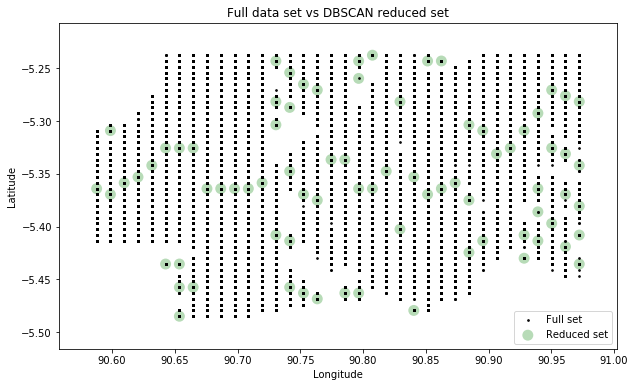

In [16]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [17]:
# map latlon clusters to geohash clusters
latlon_maps = {tuple(g): idx for idx,c in enumerate(clusters) for g in clusters[idx]}

# cluster_labels
trf_day1['cluster_ids'] = [latlon_maps[t] for t in trf_day1['latlon']]

In [18]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372,49
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358,50
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673,15
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591,42
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728,11


In [19]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [20]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
3179059,qp0d5t,26,2:30,0.007525,2019-04-26 02:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True
1762378,qp0d5t,28,1:15,0.006077,2019-04-28 01:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True
2498305,qp0d5t,28,1:45,0.002973,2019-04-28 01:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True
2674683,qp0d5t,28,9:0,0.003270,2019-04-28 09:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True
2019145,qp0d5t,28,9:15,0.004742,2019-04-28 09:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True


# set highest_demand and average demand to cluster

In [21]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [22]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
3179059,qp0d5t,26,2:30,0.007525,2019-04-26 02:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True,True,0.006593
1762378,qp0d5t,28,1:15,0.006077,2019-04-28 01:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True,True,0.006593
2498305,qp0d5t,28,1:45,0.002973,2019-04-28 01:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True,True,0.006593
2674683,qp0d5t,28,9:0,0.003270,2019-04-28 09:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True,True,0.006593
2019145,qp0d5t,28,9:15,0.004742,2019-04-28 09:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,78,True,True,0.006593


# visualize time, center point and highest demand

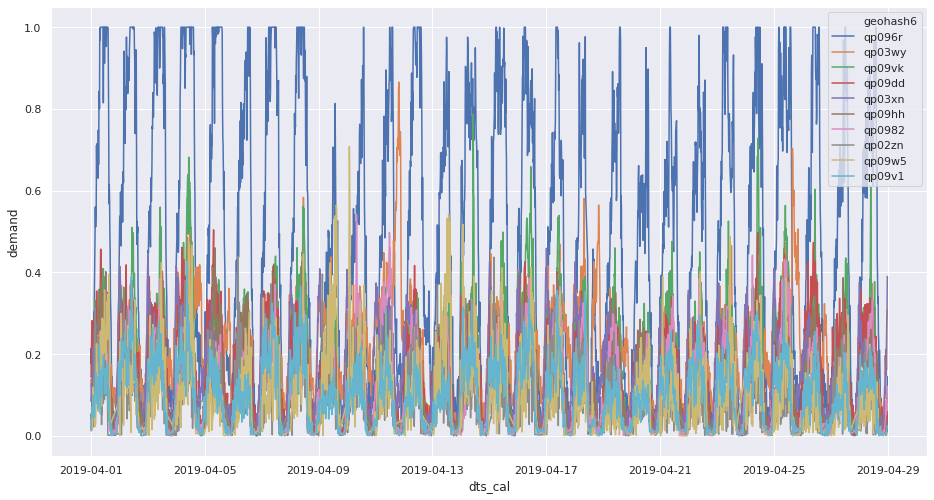

In [23]:
# observation 10 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:10]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

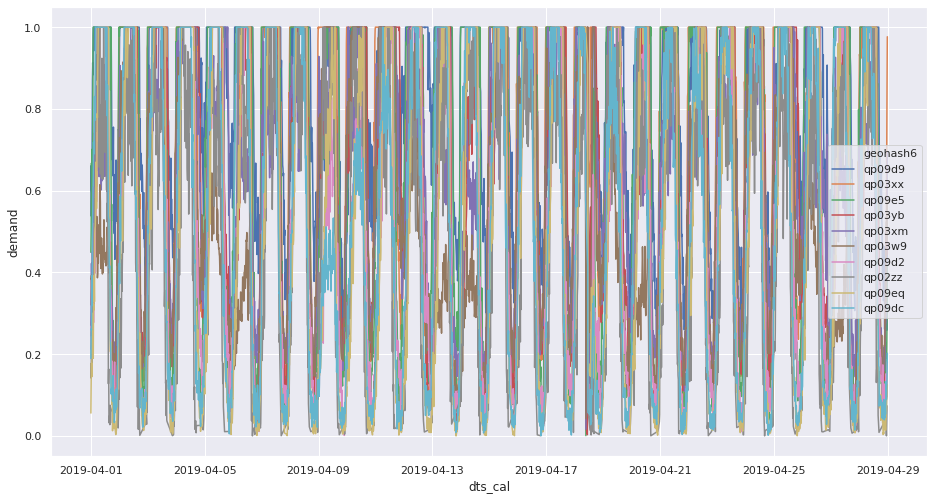

In [24]:
# observation 10 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:10]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [25]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [26]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = len(day_ids)
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,1,0:0,0.538371,2019-04-01 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,26,False,True,0.843571
1,qp03xx,1,0:0,0.320478,2019-04-01 00:00:00,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646,4,False,True,0.747063
2,qp09e5,1,0:0,0.449159,2019-04-01 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,30,False,True,0.742053
3,qp03yb,1,0:0,0.244790,2019-04-01 00:00:00,"(-5.31463623046875, 90.6536865234375)",-5.314636,90.653687,14,False,True,0.688206
4,qp03xm,1,0:0,0.261962,2019-04-01 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,3,False,True,0.658640
5,qp03w9,1,0:0,0.383662,2019-04-01 00:00:00,"(-5.35308837890625, 90.6427001953125)",-5.353088,90.642700,13,False,True,0.601830
6,qp09d2,1,0:0,0.268345,2019-04-01 00:00:00,"(-5.35858154296875, 90.8074951171875)",-5.358582,90.807495,25,False,True,0.583376
7,qp02zz,1,0:0,0.176994,2019-04-01 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,5,False,True,0.560322
8,qp09eq,1,0:0,0.055975,2019-04-01 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,29,False,True,0.539831
9,qp09dc,1,0:0,0.189483,2019-04-01 00:00:00,"(-5.35308837890625, 90.8294677734375)",-5.353088,90.829468,27,False,True,0.536179


# visualize after zero fill gap

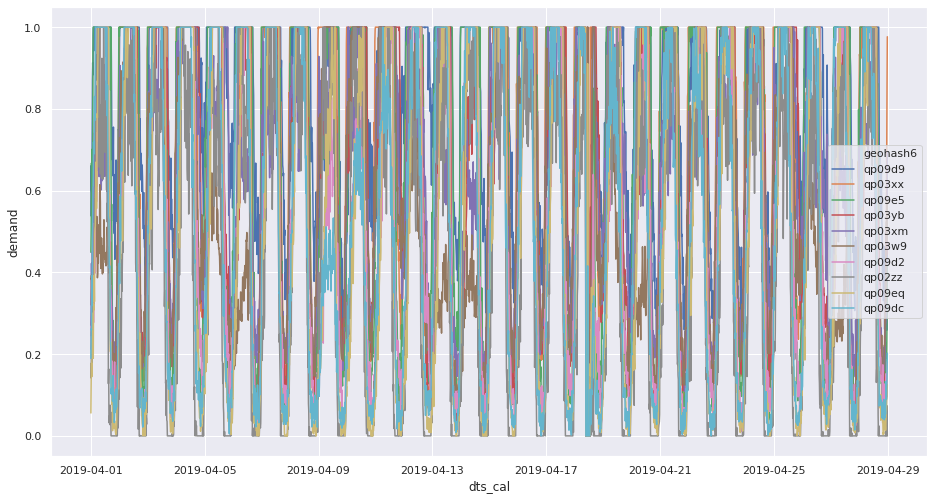

In [27]:
# observation 10 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:10]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [28]:
# prepare sorted data
total_sequence_series = 24*4*multiplier # 15 minutes within 24*multiplier hours
#past_length = int(((multiplier-1) / multiplier)*total_sequence_series)
prediction_length = int(24*4*(multiplier/2))
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
print("total_sequence_series: %s, prediction_length: %s" % (total_sequence_series, prediction_length))
trf_day1_complete_sort[:5]

total_sequence_series: 2688, prediction_length: 1344


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
65,qp02yc,1,0:0,0.0,2019-04-01 00:00:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.020251
144,qp02yc,1,0:15,0.0,2019-04-01 00:15:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.020251
223,qp02yc,1,0:30,0.0,2019-04-01 00:30:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.020251
302,qp02yc,1,0:45,0.0,2019-04-01 00:45:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.020251
381,qp02yc,1,1:0,0.0,2019-04-01 01:00:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.020251


In [29]:
# grouping and prepare prerequisite data
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

In [30]:
# weekly prediction using keras
from lib import keras_timeseries

# setup train and test data for keras
train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]
test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[total_sequence_series-prediction_length:]] for c in cluster_list]

X_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in train_day1_ds]))
X_data = X_mat.round(15).reshape(len(cluster_list), total_sequence_series-prediction_length, 1)
y_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in test_day1_ds]))
y_data = y_mat.round(15).reshape(len(cluster_list), prediction_length, 1)

test_count = int(0.5*X_data.shape[0])
test_count = test_count if test_count < 32 else 32*ceil(test_count / 32)
X_train = X_data[:-(X_data.shape[0]-test_count)]
X_test = X_data[X_data.shape[0]-test_count:]

#print(X_train.shape, X_test.shape)

y_train = y_data[:-(y_data.shape[0]-test_count)]
y_test = y_data[y_data.shape[0]-test_count:]

#print(y_train.shape, y_test.shape)

N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
train_batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 24 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series
test_batch_size = X_test.shape[0]

inputs, outputs = \
    [keras_timeseries.stateful_cut(arr, train_batch_size, T_after_cut) for arr in \
    [X_train, y_train]]
inputs_test, outputs_test = \
    [keras_timeseries.stateful_cut(arr, test_batch_size, T_after_cut) for arr in \
    [X_test, y_test]]
#inputs, outputs, inputs_test, outputs_testtest_count = test_count if test_count < 32 else 32*ceil(test_count / 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3584 samples, validate on 3584 samples
Epoch 1/500
3584/3584 [==============================] - 1s 348us/step - loss: 0.0632 - val_loss: 0.0355
Epoch 2/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0475 - val_loss: 0.0301
Epoch 3/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0380 - val_loss: 0.0243
Epoch 4/500
3584/3584 [==============================] - 1s 199us/step - loss: 0.0287 - val_loss: 0.0178
Epoch 5/500
3584/3584 [==============================] - 1s 222us/step - loss: 0.0199 - val_loss: 0.0121
Epoch 6/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0135 - val_loss: 0.0091
Epoch 7/500
3584/3584 [==============================] - 1s 213us/step - loss: 0.0107 - val_loss: 0.0083
Epoch 8/500
3584/3584 [==============================] - 1s 225us/step - loss: 0.0100 - val_loss:

3584/3584 [==============================] - 1s 224us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 73/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 74/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 75/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 76/500
3584/3584 [==============================] - 1s 202us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 77/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 78/500
3584/3584 [==============================] - 1s 240us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 79/500
3584/3584 [==============================] - 1s 219us/step - loss: 0.0092 - val_loss: 0.0078
Epoch 80/500
3584/3584 [==============================] - 1s 213us/step - loss: 0.0091 - val_loss: 0.0078
Epoch 81/500
3584/3584 [==============================] - 1

Epoch 149/500
3584/3584 [==============================] - 1s 225us/step - loss: 0.0091 - val_loss: 0.0078
Epoch 150/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0091 - val_loss: 0.0078
Epoch 151/500
3584/3584 [==============================] - 1s 222us/step - loss: 0.0091 - val_loss: 0.0078
Epoch 152/500
3584/3584 [==============================] - 1s 209us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 153/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 154/500
3584/3584 [==============================] - 1s 232us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 155/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 156/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 157/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 158/500
3584/3584 [============

3584/3584 [==============================] - 1s 201us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 226/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 227/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 228/500
3584/3584 [==============================] - 1s 225us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 229/500
3584/3584 [==============================] - 1s 212us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 230/500
3584/3584 [==============================] - 1s 209us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 231/500
3584/3584 [==============================] - 1s 243us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 232/500
3584/3584 [==============================] - 1s 207us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 233/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 234/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 205us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 302/500
3584/3584 [==============================] - 1s 220us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 303/500
3584/3584 [==============================] - 1s 226us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 304/500
3584/3584 [==============================] - 1s 210us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 305/500
3584/3584 [==============================] - 1s 213us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 306/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 307/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 308/500
3584/3584 [==============================] - 1s 205us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 309/500
3584/3584 [==============================] - 1s 200us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 310/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 200us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 378/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 379/500
3584/3584 [==============================] - 1s 211us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 380/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 381/500
3584/3584 [==============================] - 1s 209us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 382/500
3584/3584 [==============================] - 1s 215us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 383/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 384/500
3584/3584 [==============================] - 1s 206us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 385/500
3584/3584 [==============================] - 1s 202us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 386/500
3584/3584 [==========================

3584/3584 [==============================] - 1s 213us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 454/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 455/500
3584/3584 [==============================] - 1s 200us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 456/500
3584/3584 [==============================] - 1s 208us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 457/500
3584/3584 [==============================] - 1s 208us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 458/500
3584/3584 [==============================] - 1s 203us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 459/500
3584/3584 [==============================] - 1s 214us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 460/500
3584/3584 [==============================] - 1s 204us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 461/500
3584/3584 [==============================] - 1s 209us/step - loss: 0.0091 - val_loss: 0.0077
Epoch 462/500
3584/3584 [==========================

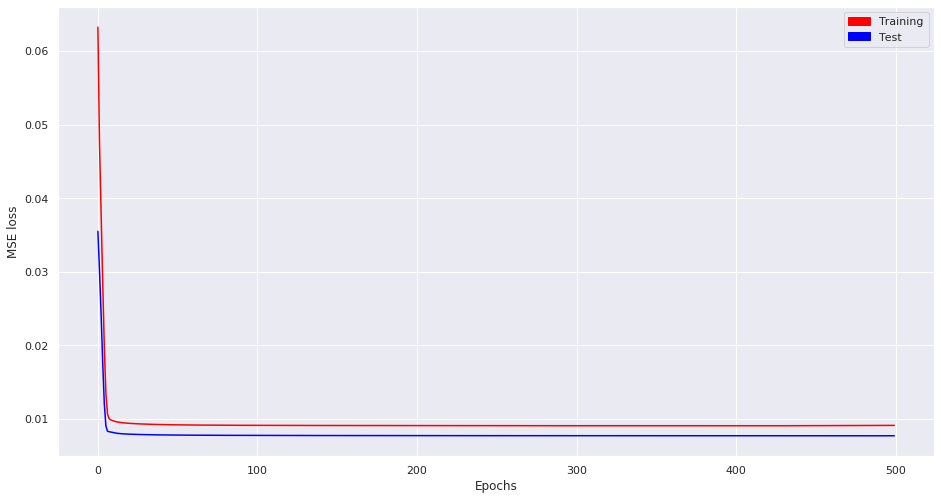

In [31]:
# building network and training
model = keras_timeseries.build_model(train_batch_size, int(total_sequence_series/T), dim_in, dim_out, T_after_cut)
epochs = 500
history = keras_timeseries.train_model(model, inputs, outputs, inputs_test, outputs_test,
                N, T, epochs, train_batch_size, test_batch_size, T_after_cut)
keras_timeseries.plotting(history)

# saving the model
model_path = 'model/keras-epoch%s-stateful-%sdays.lstm' % (epochs, len(day_ids))
model.save(model_path)

In [32]:
# predicting and evaluating
model = load_model(model_path)

interval=64
first_idx = range(0, interval)
second_idx = range(len(cluster_list)-interval, len(cluster_list))

first_x = X_data[first_idx]
first_y = y_data[first_idx]
first_yhat = model.predict(first_x, batch_size=interval)

second_x = X_data[second_idx]
second_y = y_data[second_idx]
second_yhat = model.predict(second_x, batch_size=interval)

actual_x = [first_x[c] for c in first_idx]
actual_x.extend([second_x[c] for c in range(interval-(len(cluster_list)-interval), interval)])
actual_y = [first_y[c] for c in first_idx]
actual_y.extend([second_y[c] for c in range(interval-(len(cluster_list)-interval), interval)])
predicted_y = [first_yhat[c] for c in first_idx]
predicted_y.extend([second_yhat[c] for c in range(interval-(len(cluster_list)-interval), interval)])

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'cluster_ids': [],
    'ts': []})

actual_x_df = pd.DataFrame([actual_x[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
actual_y_df = pd.DataFrame([actual_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
predicted_x_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in cluster_list])
predicted_y_df = pd.DataFrame([predicted_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])

result_df['cluster_ids'] = [c for _ in interval_time for c in cluster_list]
result_df['ts'] = [start_date + t for t in interval_time for _ in cluster_list]
actual_result = actual_x_df.append(actual_y_df)
predicted_result = predicted_x_df.append(predicted_y_df)
result_df = result_df.sort_values(['ts', 'cluster_ids'])
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

#result_df[result_df.cluster_ids == 0]
top_result_df = result_df[result_df.cluster_ids.isin(top_clusters)]

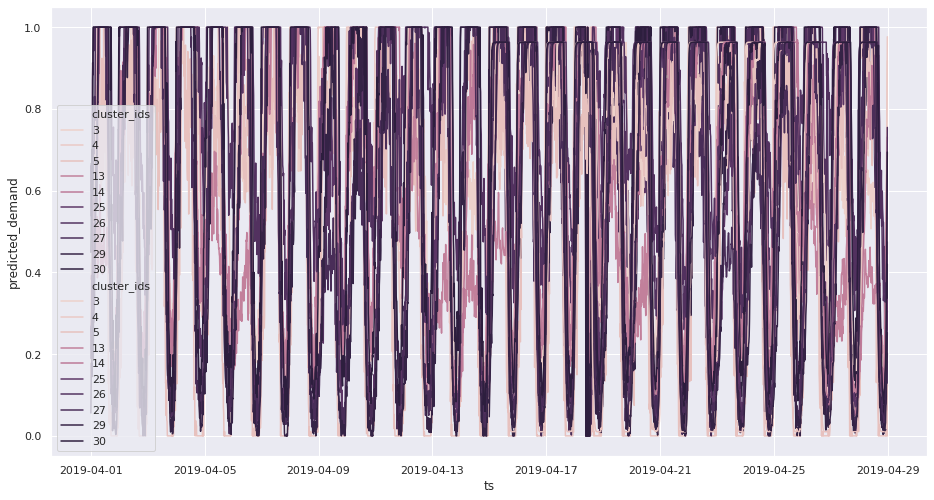

In [33]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")
ax = sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")

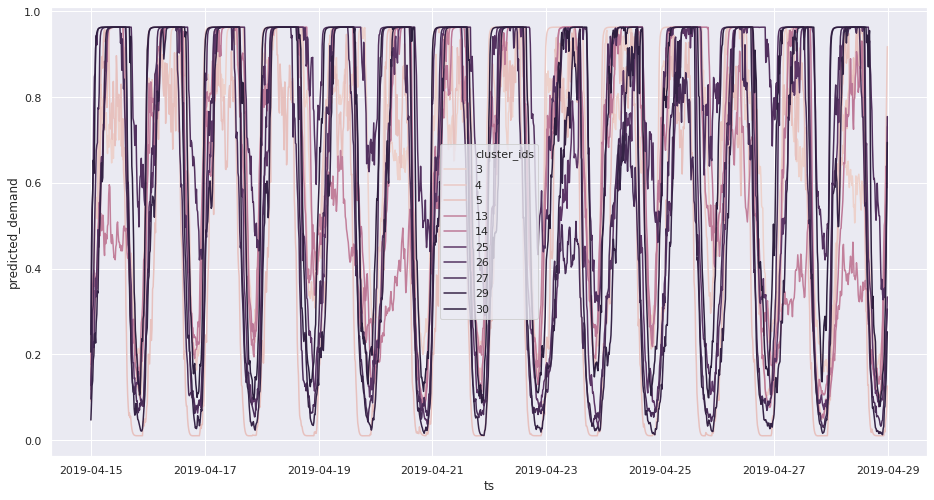

In [34]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", data=top_result_df, legend="full")
plt.show()

# find predicted demand of a geohash point by datetime

In [35]:
def measure_distance(x1, y1, x2, y2):
    R = 6373.0

    lat1 = radians(x1)
    lon1 = radians(y1)
    lat2 = radians(x2)
    lon2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [36]:
trf_day1[(trf_day1.is_centroid == False) & (trf_day1.highest_demand == False)].sort_values(['dts_cal'])

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
407279,qp09h0,1,0:0,0.003304,2019-04-01 00:00:00,"(-5.44647216796875, 90.8843994140625)",-5.446472,90.884399,33,False,False,0.037294
1323868,qp093q,1,0:0,0.000553,2019-04-01 00:00:00,"(-5.36956787109375, 90.7635498046875)",-5.369568,90.763550,35,False,False,0.036497
1753586,qp091q,1,0:0,0.005874,2019-04-01 00:00:00,"(-5.41351318359375, 90.7635498046875)",-5.413513,90.763550,35,False,False,0.018816
533520,qp099r,1,0:0,0.021819,2019-04-01 00:00:00,"(-5.32012939453125, 90.7635498046875)",-5.320129,90.763550,35,False,False,0.021511
3797498,qp093r,1,0:0,0.034020,2019-04-01 00:00:00,"(-5.36407470703125, 90.7635498046875)",-5.364075,90.763550,35,False,False,0.065277
3159599,qp099q,1,0:0,0.034187,2019-04-01 00:00:00,"(-5.32562255859375, 90.7635498046875)",-5.325623,90.763550,35,False,False,0.023463
2182680,qp0993,1,0:0,0.040202,2019-04-01 00:00:00,"(-5.35308837890625, 90.7635498046875)",-5.353088,90.763550,35,False,False,0.092720
472209,qp0996,1,0:0,0.046118,2019-04-01 00:00:00,"(-5.34759521484375, 90.7635498046875)",-5.347595,90.763550,35,False,False,0.079723
267398,qp099k,1,0:0,0.070087,2019-04-01 00:00:00,"(-5.33660888671875, 90.7635498046875)",-5.336609,90.763550,35,False,False,0.097491
3939099,qp03w8,1,0:0,0.105779,2019-04-01 00:00:00,"(-5.35858154296875, 90.6427001953125)",-5.358582,90.642700,13,False,False,0.233636


In [37]:
# prepare data day n+(n/2) for evaluation
initial_week3 = day_ids[-1] + 1
num_of_days = int(len(day_ids) / 2)
trf_week3 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_week3) & (trf_df_sort.day < (initial_week3 + num_of_days))])
trf_week3 = trf_week3.sort_values(['geohash6', 'dts_cal'])
geohash_list = list(set([c for c in trf_week3['geohash6']]))

trf_week3_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': []})
interval_time = [datetime.timedelta(days=initial_week3,minutes=15*t) for t in range(24*4*num_of_days)]
gh = trf_week3.groupby(['geohash6', 'dts_cal'])['geohash6'].apply(list)
demand = trf_week3.groupby(['geohash6', 'dts_cal'])['demand'].apply(list)

trf_week3_complete['geohash6'] = [gh[c][0][0] for _ in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in geohash_list]
trf_week3_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in geohash_list]
trf_week3_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in geohash_list]
trf_week3_complete

,geohash6,day,timestamp,demand,dts_cal
0,qp03zd,1,0:0,0.091427,2019-04-29 00:00:00
1,qp093t,1,0:0,0.000000,2019-04-29 00:00:00
2,qp09g4,1,0:0,0.005684,2019-04-29 00:00:00
3,qp03zq,1,0:0,0.000000,2019-04-29 00:00:00
4,qp09ch,1,0:0,0.000000,2019-04-29 00:00:00
5,qp03jq,1,0:0,0.018324,2019-04-29 00:00:00
6,qp08b6,1,0:0,0.000000,2019-04-29 00:00:00
7,qp095b,1,0:0,0.028737,2019-04-29 00:00:00
8,qp09d0,1,0:0,0.000000,2019-04-29 00:00:00
9,qp09tv,1,0:0,0.000000,2019-04-29 00:00:00


In [38]:
# find input point's distance from centermost
input_point = 'qp09ux' # 1 cluster sample
input_point = 'qp096h'
#input_point = 'qp09hm'
latlon = geohash.decode(input_point)
#latlon
trf_day1_dist = pd.DataFrame(trf_day1)
trf_day1_dist['distance'] = trf_day1_dist.latlon.apply(lambda latlon2: measure_distance(latlon[0], latlon[1], latlon2[0], latlon2[1]))
trf_day1_dist = trf_day1_dist.sort_values(['distance', 'dts_cal'])
search_cluster = trf_day1_dist['cluster_ids'].iloc[0]
data_sample = trf_day1_complete[(trf_day1_complete.cluster_ids == search_cluster) & (trf_day1_complete.highest_demand == True)]
sample_geohash = data_sample['geohash6'].iloc[0]
trf_week3_eval = trf_week3[(trf_week3.geohash6 == sample_geohash)]

interval=64
first_idx = range(0, interval)
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]

X_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
y_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[total_sequence_series-prediction_length:])] for _ in first_idx]]
predicted_actual_data = model.predict(X_actual_data, batch_size=interval)

eval_sample = trf_week3_complete[trf_week3_complete.geohash6 == sample_geohash]
X_eval_data = predicted_actual_data
y_eval_data = [[[[eval_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
predicted_eval_data = model.predict(X_eval_data, batch_size=interval)


# actual vs predicted per cluster highest demand

In [39]:
X_actual_df = pd.DataFrame([X_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_actual_df = pd.DataFrame([y_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
X_predicted_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in first_idx[:1]])
y_predicted_df = pd.DataFrame([predicted_actual_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

y_eval_df = pd.DataFrame([y_eval_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_predicted_eval_df = pd.DataFrame([predicted_eval_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

ext_interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*(multiplier+num_of_days))]

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'predicted_50_quant': [],
    'predicted_90_quant': [],
    'ts': []})

result_df['ts'] = [start_date + t for t in ext_interval_time for _ in first_idx[:1]]
#result_df['ts'] = [datetime.datetime.timestamp(start_date + t) for t in ext_interval_time for _ in first_idx[:1]]
#print(len([start_date + t for t in ext_interval_time for _ in first_idx[:1]]))

#rng = pd.date_range('2019-04-01 00:00:00', periods=24*4*(multiplier+num_of_days), freq='15min')
#result_df['ts'] = rng
#result_df.set_index(['ts'])
#result_df.index = pd.to_datetime(result_df.index, unit='s')

actual_result = X_actual_df.append(y_actual_df).append(y_eval_df)
predicted_result = X_predicted_df.append(y_predicted_df).append(y_predicted_eval_df)
result_df = result_df.sort_values(['ts'])
result_df['ts'] = pd.to_datetime(result_df.ts)
result_df.index = pd.DatetimeIndex(result_df.ts)
result_df.set_index('ts')
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

g = result_df.groupby([pd.Grouper(freq='H')])
result_df['predicted_50_quant'] = g.quantile(0.50)['predicted_demand']
result_df['predicted_90_quant'] = g.quantile(0.90)['predicted_demand']

result_df
#melted_df = pd.melt(result_df, id_vars=[], 
#                   value_vars=result_df['ts'],
#                   value_name='predicted_demand',
#                   var_name=['ts'])
#melted_df

,actual_demand,predicted_demand,predicted_50_quant,predicted_90_quant,ts
ts,,,,,
2019-04-01 00:00:00,0.022354,NaN,NaN,NaN,2019-04-01 00:00:00
2019-04-01 00:15:00,0.082794,NaN,NaN,NaN,2019-04-01 00:15:00
2019-04-01 00:30:00,0.147150,NaN,NaN,NaN,2019-04-01 00:30:00
2019-04-01 00:45:00,0.134028,NaN,NaN,NaN,2019-04-01 00:45:00
2019-04-01 01:00:00,0.097637,NaN,NaN,NaN,2019-04-01 01:00:00
2019-04-01 01:15:00,0.134175,NaN,NaN,NaN,2019-04-01 01:15:00
2019-04-01 01:30:00,0.158197,NaN,NaN,NaN,2019-04-01 01:30:00
2019-04-01 01:45:00,0.183178,NaN,NaN,NaN,2019-04-01 01:45:00
2019-04-01 02:00:00,0.072916,NaN,NaN,NaN,2019-04-01 02:00:00


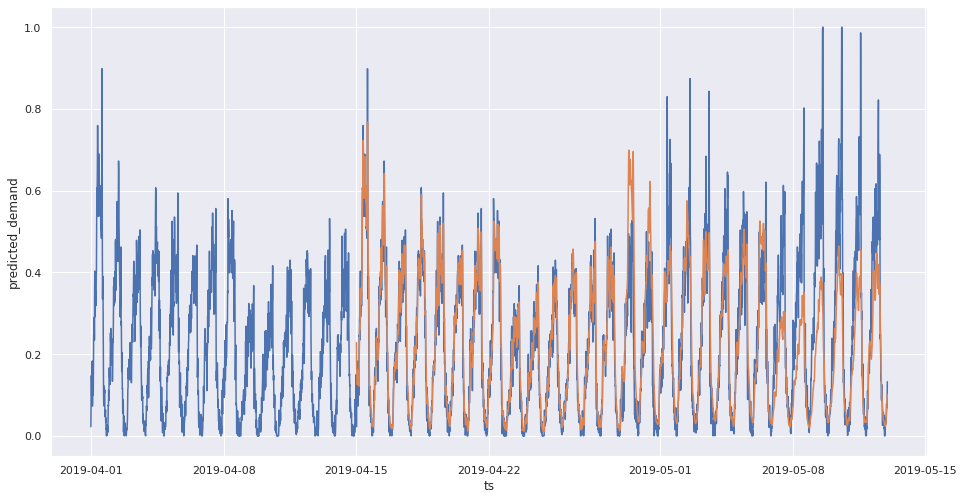

In [40]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", data=result_df, ax=ax)
ax = sns.lineplot(x="ts", y="predicted_demand", data=result_df, ci="sd", err_style="band", ax=ax)
#ax = sns.lineplot(x="ts", y="predicted_50_quant", data=result_df, ci=50, ax=ax, legend="full")
#ax = sns.lineplot(x="ts", y="predicted_90_quant", data=result_df, ci=90, ax=ax, legend="full")
#sns.tsplot([result_df.actual_demand, result_df.predicted_demand])